In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from textwrap import wrap
import re
import string

In [3]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

In [4]:
id_sub = df_test['id']

In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### ANÁLISIS EXPLORATORIO

In [6]:
df_train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

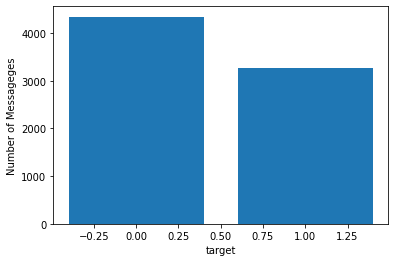

In [7]:
Category_count=df_train.groupby('target').count()
plt.bar(Category_count.index.values, Category_count['text'])
plt.xlabel('target')
plt.ylabel('Number of Messageges')
plt.show()

In [8]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

### LIMPIEZA DE LOS DATOS

In [9]:
def remove_emoji(text):
    emoji_pattern = re.compile(
      '['
      u'\U0001F600-\U0001F64F'  # emoticons
      u'\U0001F300-\U0001F5FF'  # symbols & pictographs
      u'\U0001F680-\U0001F6FF'  # transport & map symbols
      u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
      u'\U00002702-\U000027B0'
      u'\U000024C2-\U0001F251'
      ']+',
      flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
    
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

df_train['text'] = df_train['text'].map(remove_url)
df_train['text'] = df_train['text'].map(remove_emoji)
df_test['text'] = df_test['text'].map(remove_url)
df_test['text'] = df_test['text'].map(remove_emoji)

### Se crean los dataframe de los datos para entrenar

In [10]:
df_bert = pd.DataFrame(df_train['text'], columns=['text'])
df_bert['target'] = df_train['target']
df_bert.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
df_bert_test = pd.DataFrame(df_test['text'], columns=['text'])
df_bert_test.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


### MODELO BERT

In [12]:
# INICIALIZACIÓN
RANDOM_SEED = 29
MAX_LEN = 120
BATCH_SIZE = 32
NCLASSES = 2

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
# TOKENIZACIÓN
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
#PRE_TRAINED_MODEL_NAME = 'bert-large-uncased'
#PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [14]:
# CREACIÓN DATASET

class TweetDataset(Dataset):

  def __init__(self,tweet,labels,tokenizer,max_len):
    self.tweet = tweet
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.tweet)
    
  def __getitem__(self, item):
    tweet = str(self.tweet[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        tweet,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
        )
    

    return {
          'text': tweet,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
    }

In [15]:
# DATA LOADER

def data_loader(df_train, tokenizer, max_len, batch_size):
  dataset = TweetDataset(
      tweet = df_train.text.to_numpy(),
      labels = df_train.target.to_numpy(),
      tokenizer = tokenizer,
      max_len = MAX_LEN
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)

In [16]:
# DATOS DE ENTRENAMIENTO Y TEST

X_train, X_test = train_test_split(df_train, test_size = 0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(X_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(X_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
# EL MODELO

class BERTDisasterTweet(nn.Module):

  def __init__(self, n_classes):
    super(BERTDisasterTweet, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(input_ids = input_ids, attention_mask = attention_mask, return_dict=False)
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output

In [18]:
model = BERTDisasterTweet(NCLASSES)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
# ENTRENAMIENTO

EPOCHS = 1
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [20]:
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()
    return correct_predictions.double()/n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double()/n_examples, np.mean(losses)

In [21]:
for epoch in range(EPOCHS):
  print('Epoch {} de {}'.format(epoch+1, EPOCHS))
  print('------------------')
  train_acc, train_loss = train_model(
      model, train_data_loader, loss_fn, optimizer, device, scheduler, len(X_train)
  )
  test_acc, test_loss = eval_model(
      model, test_data_loader, loss_fn, device, len(X_test)
  )
  print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
  print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
  print('')

Epoch 1 de 1
------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Entrenamiento: Loss: 0.44248199291254214, accuracy: 0.8029556650246306
Validación: Loss: 0.39326521071294945, accuracy: 0.8371634931057124



### Predicción de los resultados

In [22]:
def classifyTweet(tweet_text):
  encoding_review = tokenizer.encode_plus(
      tweet_text,
      max_length = MAX_LEN,
      truncation = True,
      add_special_tokens = True,
      return_token_type_ids = False,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_tensors = 'pt'
      )
  
  input_ids = encoding_review['input_ids'].to(device)
  attention_mask = encoding_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  if prediction:
    return 1
  else:
    return 0

In [23]:
# Se crea un dataframe con los datos para hacer el envío a Kaggle
df_submit = pd.DataFrame(id_sub, columns=['id'])
df_submit['target'] = df_test['text'].apply(classifyTweet)
df_submit.head()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [24]:
df_submit.to_csv('submission.csv')